In [1]:
import torch
from functorch import make_functional, vmap, grad
from sklearn.cluster import KMeans
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Functions

In [3]:


def compute_per_sample_gradients(model, loss_fn, inputs, targets):
    # Convert the model into a functional version
    fmodel, params = make_functional(model)
    
    # Define a function that computes the loss for a single sample
    def compute_loss(params, input, target):
        # Rebuild the model with the given parameters
        output = fmodel(params, input)
        loss = loss_fn(output, target)
        return loss

    # Get the gradients of the loss with respect to the model parameters
    grad_fn = grad(compute_loss)
    
    # Use vmap to compute per-sample gradients efficiently
    per_sample_grads = vmap(grad_fn, (None, 0, 0))(params, inputs, targets)
    # per_sample_grads is a tuple where each element corresponds to a parameter

    # Flatten and stack the gradients for each sample
    batch_size = inputs.shape[0]
    flattened_grads = []
    for i in range(batch_size):
        sample_grads = []
        for param_grad in per_sample_grads:
            sample_grads.append(param_grad[i].reshape(-1))
        flattened_grads.append(torch.cat(sample_grads))
    flattened_grads = torch.stack(flattened_grads)  # Shape: (batch_size, num_params)
    return flattened_grads


In [4]:
def cluster_gradients(flattened_grads, n_clusters):
    # Convert to numpy for scikit-learn compatibility
    grads_np = flattened_grads.detach().cpu().numpy()
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(grads_np)
    return cluster_labels


In [5]:
def compute_cluster_averages(flattened_grads, cluster_labels, n_clusters):
    cluster_avgs = []
    for k in range(n_clusters):
        indices = torch.where(torch.tensor(cluster_labels) == k)[0]
        cluster_grads = flattened_grads[indices]
        cluster_avg = cluster_grads.mean(dim=0)
        cluster_avgs.append(cluster_avg)
    cluster_avgs = torch.stack(cluster_avgs)  # Shape: (n_clusters, num_params)
    return cluster_avgs

In [6]:
def orthogonalize_vectors(vectors):
    orthogonal_vectors = []
    for v in vectors:
        w = v.clone()
        for u in orthogonal_vectors:
            proj = torch.dot(w, u) / torch.dot(u, u) * u
            w = w - proj
        orthogonal_vectors.append(w)
    orthogonal_vectors = torch.stack(orthogonal_vectors)
    return orthogonal_vectors


In [7]:
def combine_gradients(orthogonal_vectors):
    combined_grad = orthogonal_vectors.sum(dim=0)
    return combined_grad


In [8]:
def update_model(model, combined_grad, learning_rate):
    # Unflatten the combined gradient and assign to model parameters
    index = 0
    for param in model.parameters():
        num_param = param.numel()
        param_grad = combined_grad[index:index+num_param].view_as(param)
        if param.grad is None:
            param.grad = param_grad.clone()
        else:
            param.grad.copy_(param_grad)
        index += num_param
    # Update the model parameters
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad


In [9]:

def train(model, dataloader, loss_fn, num_epochs, learning_rate, n_clusters):
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            # Ensure inputs and targets are on the correct device
            inputs, targets = inputs.to(device), targets.to(device)

            # Step 1: Compute per-sample gradients
            flattened_grads = compute_per_sample_gradients(model, loss_fn, inputs, targets)

            # Step 2: Cluster the gradient vectors
            cluster_labels = cluster_gradients(flattened_grads, n_clusters)

            # Step 3: Compute cluster averages
            cluster_avgs = compute_cluster_averages(flattened_grads, cluster_labels, n_clusters)

            # Step 4: Orthogonalize the average gradient vectors
            orthogonal_vectors = orthogonalize_vectors(cluster_avgs)

            # Step 5: Combine the orthogonalized vectors
            combined_grad = combine_gradients(orthogonal_vectors)

            # Step 6: Update the model
            update_model(model, combined_grad, learning_rate)
            
        #print the loss after each epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss_fn(model(inputs), targets).item()}")

[[-1.         -1.        ]
 [-0.97979798 -1.        ]
 [-0.95959596 -1.        ]
 ...
 [ 0.95959596  1.        ]
 [ 0.97979798  1.        ]
 [ 1.          1.        ]]


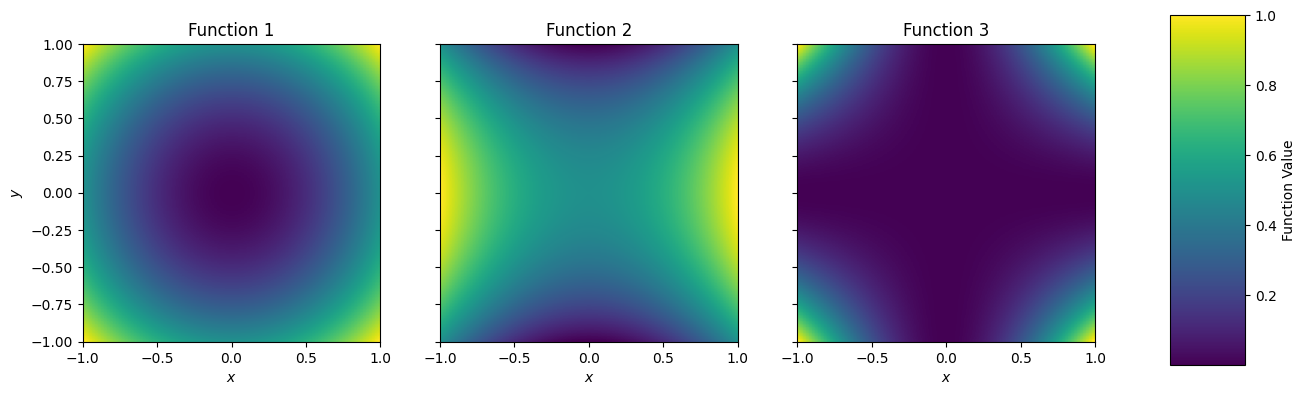

In [10]:
# Define vector function with three scalar functions
# def f_sum_decomposable(x):
#     x1, x2 = x[:,0], x[:,1]
#     return np.array([np.sin(4 * np.pi * x1) + np.sin(4 * np.pi * x2),
#             np.sin(3 * np.pi * ((x1-0.5)**2)) + np.cos(2*np.pi*((x2-0.5)**2)),
#             np.sin(6 * np.pi * (x1)**2) - np.sin(6 * np.pi * (x2)**2)]).T  

def f_sum_decomposable(x):
    x1, x2 = x[:,0], x[:,1]
    return np.array([x1**2 + x2**2,
            x1**2 - x2**2,
            x1**2 * x2**2]).T

# Create a grid of points in the domain [0, 1]^2
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X,Y = np.meshgrid(x,y)
coordinates = np.stack([X.flatten(), Y.flatten()]).T

print(coordinates)

f = f_sum_decomposable
# Compute the function values at the grid points for each functions
Z = f(coordinates)
Z = Z.reshape(100,100,3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
fig.subplots_adjust(right=0.8)

cmap="viridis"
titles=['Function 1', 'Function 2', 'Function 3']
for idx in range(3):
    im = axs[idx].imshow(Z[:,:,idx], extent=[-1, 1, -1 ,1], origin='lower', cmap=cmap)
    axs[idx].set_xlabel('$x$')
    axs[idx].set_title(titles[idx])

axs[0].set_ylabel('$y$')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Function Value')

#plt.savefig('target_function.png', dpi=300, bbox_inches='tight')
#plt.close()
plt.show()

# Control model


In [11]:
#create and train a very deep model using sgd
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 3)
        )

    def forward(self, x):
        return self.layers(x)
    
model = Model().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [12]:
#train the control model for 100 epochs using sgd on the coordinates and the target function values
num_epochs = 10
batch_size = 100
learning_rate = 0.001
n_clusters = 10

# Create a DataLoader for the dataset
dataset = torch.tensor(coordinates, dtype=torch.float32)
targets = torch.tensor(f(coordinates), dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(dataset, targets)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#create a training fucntion for the control model
def train_model(model, dataloader, loss_fn, num_epochs, learning_rate):
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            # Print the loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss.item()}")




In [18]:
train_model(model, dataloader, loss_fn, num_epochs, learning_rate)

Epoch 10, Loss: 0.04616781324148178


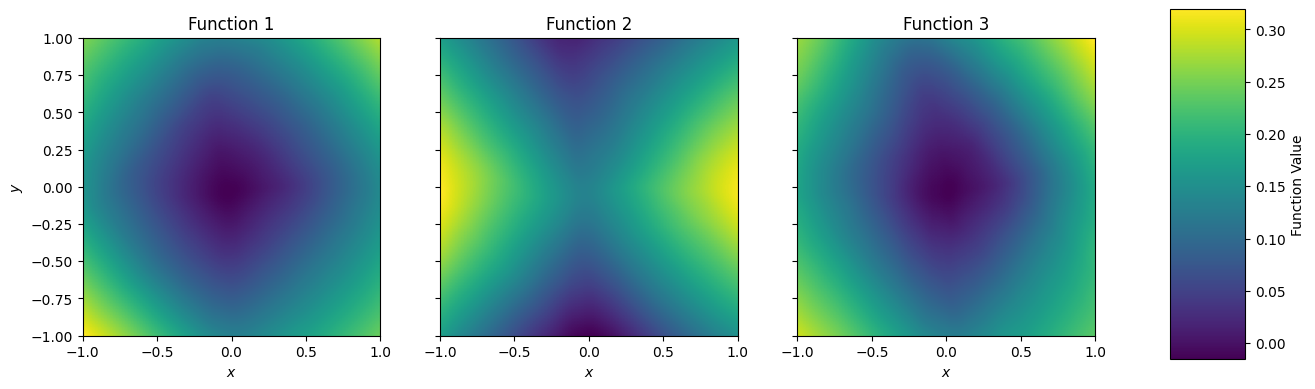

In [19]:
#using the model, plot the predictions of the model on the grid
model.eval()
with torch.no_grad():
    inputs = torch.tensor(coordinates, dtype=torch.float32).to(device)
    outputs = model(inputs).cpu().numpy()

Z_pred = outputs.reshape(100,100,3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
fig.subplots_adjust(right=0.8)

cmap="viridis"
titles=['Function 1', 'Function 2', 'Function 3']
for idx in range(3):
    im = axs[idx].imshow(Z_pred[:,:,idx], extent=[-1, 1, -1 ,1], origin='lower', cmap=cmap)
    axs[idx].set_xlabel('$x$')
    axs[idx].set_title(titles[idx])

axs[0].set_ylabel('$y$')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Function Value')

In [20]:
#test the model on 10 independent samples, record the mean and std MAE and MSE
def test_model(model, f, num_samples):
    mae = []
    mse = []
    for i in range(num_samples):
        x = np.random.uniform(-1, 1, (100, 2))
        y = f(x)
        x = torch.tensor(x, dtype=torch.float32).to(device)
        y = torch.tensor(y, dtype=torch.float32).to(device)
        with torch.no_grad():
            y_pred = model(x)
            mae.append(torch.abs(y - y_pred).mean().item())
            mse.append(((y - y_pred)**2).mean().item())
    return np.mean(mae), np.std(mae), np.mean(mse), np.std(mse)


In [21]:

num_samples = 10
mae_mean, mae_std, mse_mean, mse_std = test_model(model, f_sum_decomposable, num_samples)
print(f"MAE: {mae_mean} ± {mae_std}")
print(f"MSE: {mse_mean} ± {mse_std}")

MAE: 0.1703567996621132 ± 0.00916370720324816
MSE: 0.05250026173889637 ± 0.0048997833799888325


# COSGD Model

In [13]:
#create a new model and train it using the proposed method
COSGDmodel = Model().to(device)
train(COSGDmodel, dataloader, loss_fn, num_epochs, learning_rate, n_clusters)


C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_functorch\deprecated.py:62: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.grad is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorc

Epoch 1/10, Loss: 0.14013108611106873


C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_functorch\deprecated.py:62: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.grad is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorc

Epoch 2/10, Loss: 0.11748652160167694


C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_functorch\deprecated.py:62: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.grad is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorc

Epoch 3/10, Loss: 0.0768909826874733


C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_functorch\deprecated.py:62: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.grad is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorc

Epoch 4/10, Loss: 0.08229793608188629


C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_functorch\deprecated.py:62: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.grad is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorc

Epoch 5/10, Loss: 0.07425694912672043


C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_functorch\deprecated.py:62: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.grad is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorc

Epoch 6/10, Loss: 0.05476641282439232


C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_functorch\deprecated.py:62: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.grad is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorc

Epoch 7/10, Loss: 0.044656362384557724


C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_functorch\deprecated.py:62: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.grad is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorc

Epoch 8/10, Loss: 0.03732404112815857


C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_functorch\deprecated.py:62: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.grad is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorc

Epoch 9/10, Loss: 0.026613717898726463


C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_functorch\deprecated.py:62: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.grad is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorc

Epoch 10/10, Loss: 0.020304957404732704


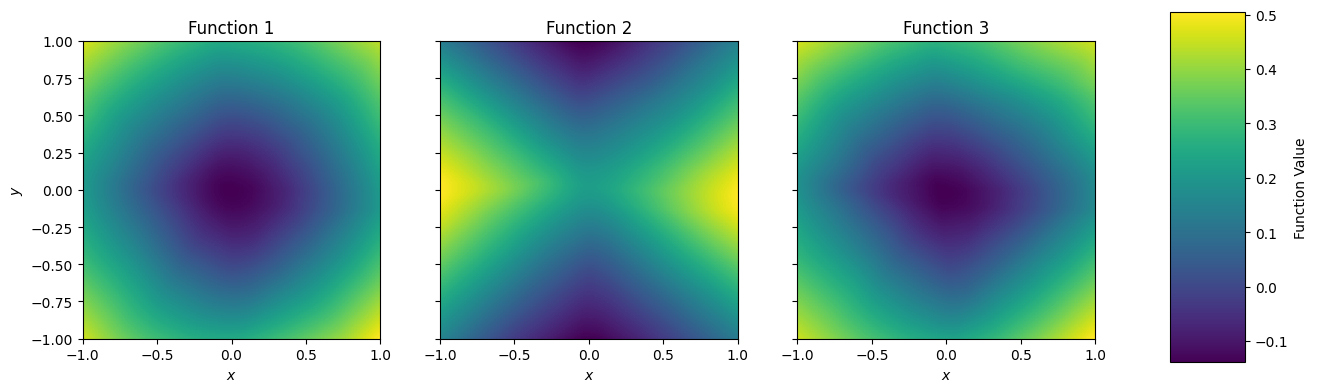

In [14]:
#using the model, plot the predictions of the model on the grid
COSGDmodel.eval()
with torch.no_grad():
    inputs = torch.tensor(coordinates, dtype=torch.float32).to(device)
    outputs = COSGDmodel(inputs).cpu().numpy()

Z_pred = outputs.reshape(100,100,3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
fig.subplots_adjust(right=0.8)

cmap="viridis"
titles=['Function 1', 'Function 2', 'Function 3']
for idx in range(3):
    im = axs[idx].imshow(Z_pred[:,:,idx], extent=[-1, 1, -1 ,1], origin='lower', cmap=cmap)
    axs[idx].set_xlabel('$x$')
    axs[idx].set_title(titles[idx])

axs[0].set_ylabel('$y$')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Function Value')




In [17]:
#test the model on 10 independent samples, record the mean and std MAE and MSE
num_samples = 10
mae_mean, mae_std, mse_mean, mse_std = test_model(COSGDmodel, f_sum_decomposable, num_samples)
print(f"MAE: {mae_mean} ± {mae_std}")
print(f"MSE: {mse_mean} ± {mse_std}")

MAE: 0.10937734022736549 ± 0.005755338406230816
MSE: 0.018657645862549543 ± 0.002063926007683919


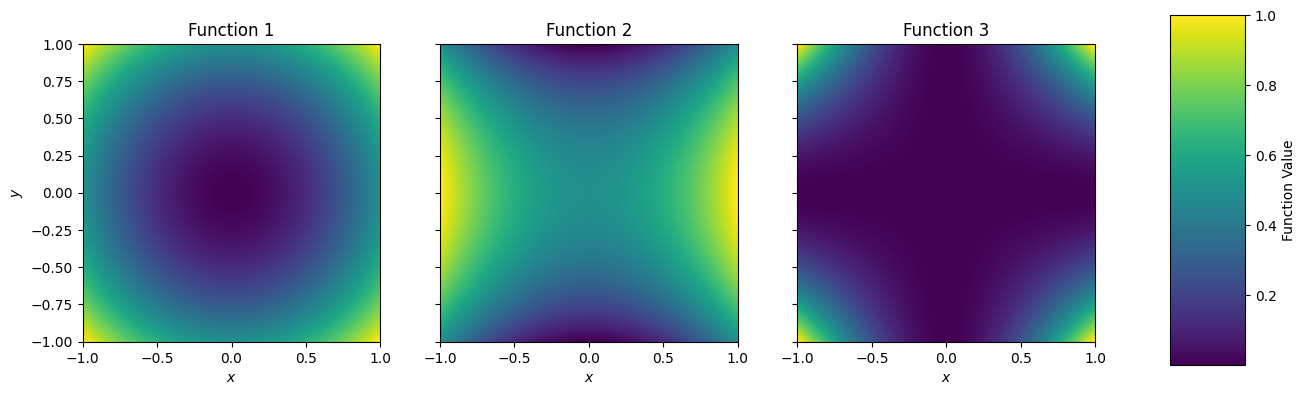

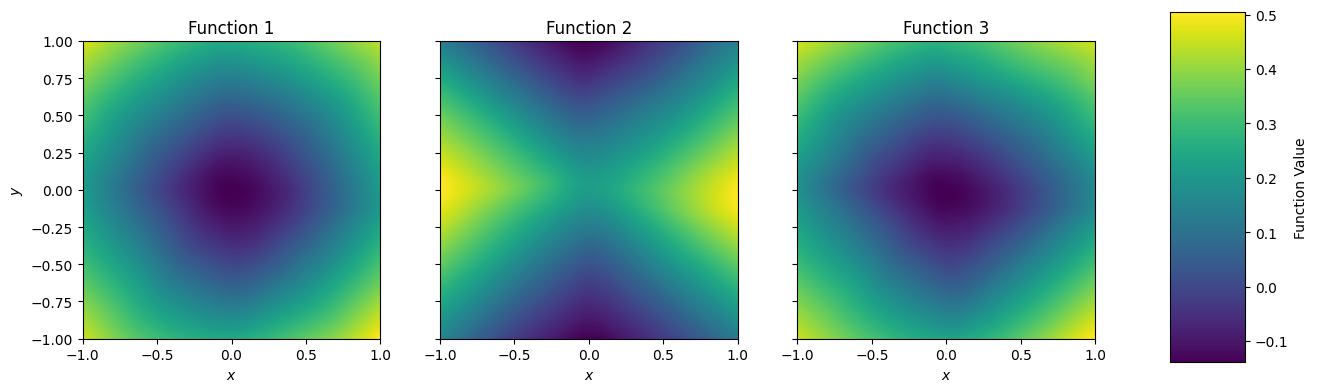

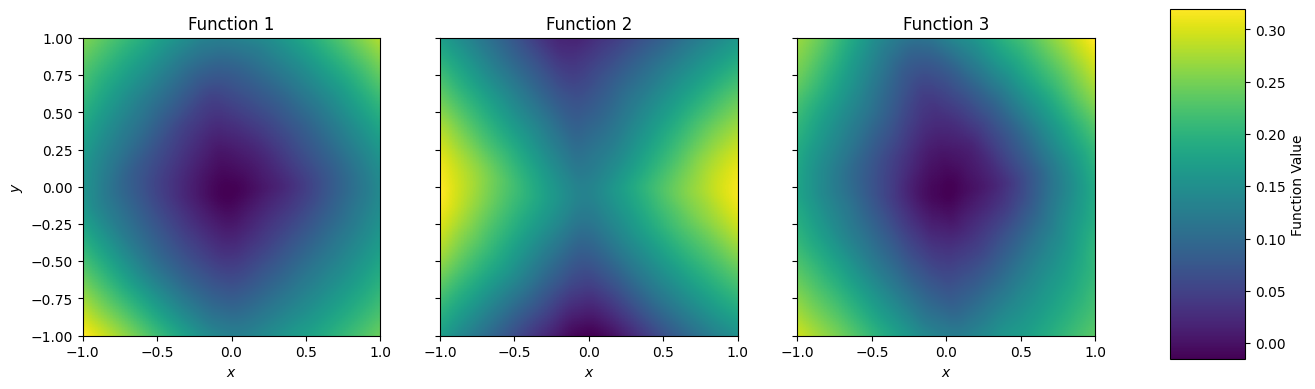

In [ ]:
MAE: 0.10937734022736549 ± 0.005755338406230816
MSE: 0.018657645862549543 ± 0.002063926007683919

In [ ]:
MAE: 0.1703567996621132 ± 0.00916370720324816
MSE: 0.05250026173889637 ± 0.0048997833799888325